In [1]:
import torch, torchvision, PIL, numpy as np
import pathlib
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from tqdm.auto import tqdm
import math
from torchvision import models, transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_dir = "/content/drive/My Drive/CPEN291 Project/data_nd"

In [4]:
df = pd.read_csv("/content/drive/My Drive/CPEN291 Project/data_nd/all_labels.csv")
n_artists = df['artist'].nunique()

In [11]:
# Copied/Adapted from SimpleModel.ipynb
class PricePredictionDataset:
    def __init__(self, root_dir, transform=None, transform_label=None):
        root_dir = pathlib.Path(root_dir).resolve()
        self.root_dir = root_dir
        self.transform = transform
        self.transform_label = transform_label
        self.a2n = {}
        self.n2a = {}
        self.labels_f = pd.read_csv(root_dir / 'all_labels.csv')
        artists_a = np.unique(self.labels_f['artist'])
        i=0
        for artist in artists_a:
          self.a2n.update({artist:i})
          self.n2a.update({i:artist})
          i = i+1

        def get_data(fn):
            fn = str(fn).rsplit('/', 1)[-1]
            row = self.labels_f.loc[self.labels_f['imageName'] == fn]
            index = row.index[0]
            artist = row['artist'][index]
            return (self.a2n[artist],row['width'][index],row['height'][index],math.log(row['price'][index])) # log because we are scientists

        self.fns_labels = [(imgfn, get_data(imgfn))
                           for imgfn in sorted(root_dir.glob('*.jpg'))]

    def __len__(self):
        return len(self.fns_labels)

    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.item()
        imgfn, data = self.fns_labels[i]
        artist, width, height, label = data
        img = PIL.Image.open(imgfn)
        if (len(img.split()) > 3): # some images have one more channel
          r,g,b, _ = img.split()
          img = PIL.Image.merge('RGB', (r,g,b))
        if (len(img.split()) == 1): # some images only have one channel
          img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)

        return (img, artist, width, height,label)

In [64]:
#vocab to deal with artists? TESTING 
artists_a = np.unique(artists)
a2n = {}
n2a = {}
i = 0
for artist in artists_a:
    a2n.update({artist:i})
    n2a.update({i:artist})
    i = i+1


In [15]:
# Adapted from SimpleModel.ipynb
def show_img_price(sample):
    img, artist, width, height, price = sample
    if torch.is_tensor(img):
        img = img.cpu().permute(1,2,0)
    plt.imshow(img)
    plt.title('a: '+dataset_full.n2a[artist]+' w: '+str(width)+' h: '+str(height)+' p: '+str(math.e**price), color='black') # add color='w' arg if using a dark background
    plt.axis('off')

In [13]:
xform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), transforms.ToTensor()])
dataset_full= PricePredictionDataset(dataset_dir, transform=xform)

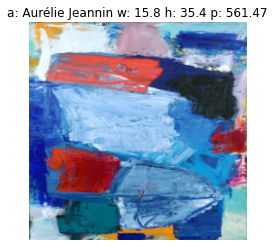

In [16]:
show_img_price(dataset_full[4])

In [194]:
#image classifier for the image
#embedding lookup for artist
#height, and width seperate straight to FC
class ArtistModel(torch.nn.Module):
    def __init__(self,n_artists):
        super().__init__()
        self.n2a = dataset_full.n2a
        self.cnn = torchvision.models.resnet34(pretrained=True)
        self.embed = torch.nn.Embedding(n_artists, 1)
        self.cnn.fc = torch.nn.Sequential(
            torch.nn.Dropout(),
            torch.nn.Linear(self.cnn.fc.in_features,1)
        )
        torch.nn.init.xavier_uniform_(self.cnn.fc[1].weight)
        torch.nn.init.xavier_uniform_(self.embed.weight)
        #1 output each of: cnn.fc, embed, and then additional 2 inputs of width and height
        self.fc1 = torch.nn.Linear(4,1)
    def forward(self, image, artist, width, height):
      cnn_out = self.cnn(image)
      embed_out = self.embed(artist)
      img_and_a = torch.cat((cnn_out,embed_out.squeeze(1)),dim=1)
      w_and_h = torch.cat((width,height),dim=1)
      fc_in = torch.cat((img_and_a,w_and_h),dim=1)
      output = self.fc1(fc_in)
      return output

      

In [195]:
torch.manual_seed(291)
model = ArtistModel(n_artists)
device = torch.device('cuda:0')
model.to(device);


In [196]:

n_all= len(dataset_full)
n_used= int(0.2 * n_all)
n_train= int(0.8 * n_used)
n_test= n_used- n_train
rng= torch.Generator().manual_seed(291)
dataset_train, dataset_test, _ = torch.utils.data.random_split(dataset_full, [n_train, n_test, n_all-n_train-n_test], rng)
print(len(dataset_train), len(dataset_test))
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 32, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 32, shuffle=True)

3103 776


In [197]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.02, weight_decay=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [198]:
def run_test(model, criterion, no_preds=False):
    nsamples_test = len(dataset_test)
    loss = 0
    preds = []
    model.eval()
    with torch.no_grad():
        for samples,artists,widths,heights, labels in loader_test:
            samples = samples.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            widths = widths.to(device).float().unsqueeze(1)
            heights = heights.to(device).float().unsqueeze(1)
            artists = artists.to(device).unsqueeze(1)
            outs = model(samples,artists,widths,heights)
            if not no_preds:
                preds += outs.cpu().unbind()
            loss += torch.sqrt(criterion(outs, labels)) * samples.size(0)
    return loss / nsamples_test, preds

def run_train(model, criterion, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar = 0
    model.train()

    with torch.enable_grad():
        for samples,artists,widths,heights, labels in tqdm(loader_train, desc='iters', leave=False):
            samples = samples.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            widths = widths.to(device).float().unsqueeze(1)
            heights = heights.to(device).float().unsqueeze(1)
            artists = artists.to(device).unsqueeze(1)
            opt.zero_grad()
            outs = model(samples,artists,widths,heights)
            loss = torch.sqrt(criterion(outs, labels))
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * samples.size(0)
            if (math.isnan(loss.item())):
              print("loss nan")
              print(loss)
    sched.step()
    return loss_sofar / nsamples_train

def run_all(model, criterion, optimizer, scheduler, n_epochs):
    for epoch in tqdm(range(n_epochs), desc='epochs'):
        loss_train = run_train(model, criterion, optimizer, scheduler)
        loss_test, _ = run_test(model, criterion, no_preds=True)
        tqdm.write(f"epoch {epoch+1}: train loss {loss_train:.4f}, test loss {loss_test:.4f}")
    return loss_test

In [199]:
run_all(model,criterion,optimizer,scheduler,10)

epoch 1: train loss 1.3303, test loss 0.8537


epoch 2: train loss 0.7728, test loss 0.7841


epoch 3: train loss 0.7614, test loss 0.6429


epoch 4: train loss 0.6432, test loss 0.5981


epoch 5: train loss 0.6345, test loss 0.5948


epoch 6: train loss 0.6249, test loss 0.5924


epoch 7: train loss 0.6117, test loss 0.5961


epoch 8: train loss 0.6144, test loss 0.5888


epoch 9: train loss 0.6066, test loss 0.5875


epoch 10: train loss 0.6051, test loss 0.5860



tensor(0.5860, device='cuda:0')

| model | fc | crit |batch size| optimizer | lr | momentum | wd | scheduler | step size | gamma| b train loss | b test loss |epochs| b epoch| notes|
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |--- |--- |--- |--- |
| resnet50 | 1 lineaar (in->1) w/dropout | rmse | 32 |AdamW | 0.01 | n/a | 0.8 | StepLR | 5 | 0.1 | 0.5662 |0.5916 |10 |8 |Better than any of the models that I tested with no artists ran on 20% of dataset
| resnet34 | 1 lineaar (in->1) w/dropout | rmse | 32 |AdamW | 0.009 | n/a | 0.8 | StepLR | 3 | 0.1 | 0.5920 |0.5819 |10 |10 |resnet34 appears to out preform resnet 50
| resnet18 | 1 lineaar (in->1) w/dropout | rmse | 32 |AdamW | 0.009 | n/a | 0.8 | StepLR | 3 | 0.1 | 0.5969 |0.5897 |10 |10 |resnet34 still seems the best
| resnet34 | 1 lineaar (in->1) w/dropout | rmse | 32 |AdamW | 0.009 | n/a | 0.5 | StepLR | 3 | 0.1 |0.5619|0.5782|10|6|Model seems to overfit since train decreases but test increases
| resnet34 | 1 lineaar (in->1) w/dropout | rmse | 32 |AdamW | 0.005 | n/a | 0.8 | StepLR | 3 | 0.1 |0.6326|0.5986|10|10|Lowering lr seems to be bad, so maybe increase?
| resnet34 | 1 lineaar (in->1) w/dropout | rmse | 32 |AdamW | 0.02 | n/a | 0.8 | StepLR | 3 | 0.1 |0.6051|0.5860|10|10|increasing does not seem to help much (better than decreasing though)

